In [1]:
from likelihood import discrete_loglikelihood
from SS_DM_Prior import SS_DM_dist_setup
from prior import discrete_logprior
import numpy as np
from scipy.special import logsumexp
from scipy import interpolate
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from time import perf_counter

# disc_prior = discrete_logprior(logfunction=lambda x, y, z, w: np.log(np.abs(y+x-w)*z), name='test',
#                                axes=(np.linspace(0,1,101), np.linspace(0,1,51),), axes_names=['energy', 'offset'],
#                                default_hyperparameter_values=(1,1), hyperparameter_names=['h1', 'h2'])

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start = perf_counter()
start

2.891008416

In [3]:
# disc_prior

In [4]:
# plt.figure()
# plt.hist2d(*disc_prior.sample(100000), bins=(50,50))
# plt.show()

In [5]:
numsamples = int(1e5)
signalfraction = 0.5

nsig = int(signalfraction*numsamples)
nbkg = int((1-signalfraction)*numsamples)

# Prior Sampling

In [6]:
darkSUSY_to_Gammapy_converter = {
    "tt": "t",
    "W+W-": "W",
    "ZZ": "Z",
    "HH": "h",
}

darkSUSY_BFs_cleaned = pd.read_csv('BFCalc/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', delimiter=' ')

darkSUSY_massvalues = darkSUSY_BFs_cleaned.iloc[:,1]/1e3

darkSUSY_lambdavalues = darkSUSY_BFs_cleaned.iloc[:,2]

channelfuncdictionary = {}

modulefolderpath = 'BFCalc'
log10xvals = np.load(modulefolderpath+f"/griddata/log10xvals_massenergy_diffflux_grid.npy")
massvalues = np.load(modulefolderpath+f"/griddata/massvals_massenergy_diffflux_grid.npy")

for darkSUSYchannel in list(darkSUSY_to_Gammapy_converter.keys()):
    gammapychannel = darkSUSY_to_Gammapy_converter[darkSUSYchannel]
    
    tempspectragrid = np.load(modulefolderpath+f"/griddata/channel={gammapychannel}_massenergy_diffflux_grid.npy")
    
    channelfuncdictionary[darkSUSYchannel] = interpolate.RegularGridInterpolator((np.log10(massvalues/1e3), log10xvals), np.array(tempspectragrid), 
                                                                                 method='linear', bounds_error=False, fill_value=1e-3000)



partial_sigmav_interpolator_dictionary = {channel: interpolate.LinearNDInterpolator((darkSUSY_massvalues, darkSUSY_lambdavalues),darkSUSY_BFs_cleaned.iloc[:,idx+3]) for idx, channel in enumerate(list(darkSUSY_to_Gammapy_converter.keys()))}



def nontrivial_coupling(logmass, logenergy, coupling=0.1, partial_sigmav_interpolator_dictionary=partial_sigmav_interpolator_dictionary, channelfuncdictionary=channelfuncdictionary ):
    
    
    logspectra = -np.inf
    for channel in channelfuncdictionary.keys():
        logspectra = np.logaddexp(logspectra, np.log(partial_sigmav_interpolator_dictionary[channel](10**logmass, coupling)*channelfuncdictionary[channel]((logmass, logenergy-logmass))))
    
    
    return logspectra
        

In [7]:
from utils3d import longitudeaxistrue, latitudeaxistrue, log10eaxistrue


logDMpriorfunc = SS_DM_dist_setup(nontrivial_coupling, longitudeaxistrue, latitudeaxistrue)

In [8]:
logenergy_true_logjacob = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]

In [9]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(1,), hyperparameter_names=['mass'], logjacob=logenergy_true_logjacob)
DM_prior

(1,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist_setup.<locals>.DM_signal_dist at 0x7fe108f23c10>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

In [10]:
sig_samples = DM_prior.sample(nsig)

In [11]:
sigpriorvalues = np.exp(logsumexp(DM_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),), (1.0,))+logenergy_true_logjacob, axis=(1,2)))

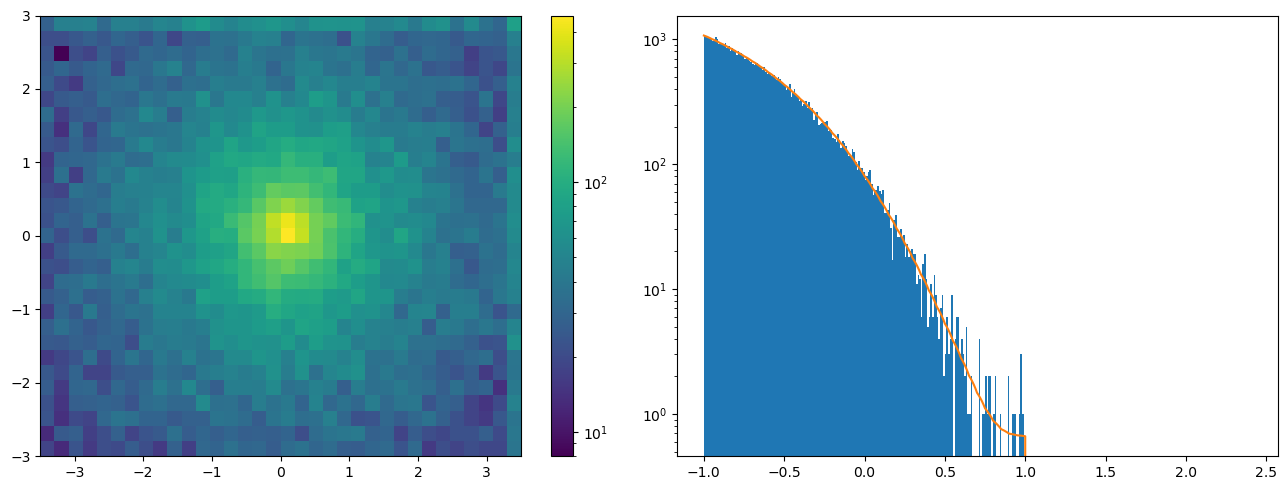

In [12]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist2d(sig_samples[1,:], sig_samples[2,:], bins=(longitudeaxistrue, latitudeaxistrue), norm=LogNorm())
plt.colorbar()

plt.subplot(1,2,2)
sigtruehistvals = plt.hist(sig_samples[0,:], bins=log10eaxistrue,)
plt.plot(log10eaxistrue, np.max(sigtruehistvals[0])*sigpriorvalues/np.max(sigpriorvalues))
plt.yscale('log')

plt.tight_layout()

In [13]:
astrophysicalbackground = np.load("unnormalised_astrophysicalbackground.npy")
from utils3d import bkgdist

nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logenergy_true_logjacob)

In [14]:
bkg_prior((0.0,0.0,0.0))

3.3067634676689934

In [15]:
bkg_samples = bkg_prior.sample(nbkg)

bkg_samples

array([[-0.4       , -0.98      , -0.64      , ..., -0.83      ,
        -0.88      , -0.84      ],
       [-1.23529412,  2.26470588, -3.5       , ..., -1.23529412,
         2.67647059,  1.23529412],
       [-0.72413793,  1.75862069, -1.55172414, ..., -1.13793103,
        -1.13793103, -0.51724138]])

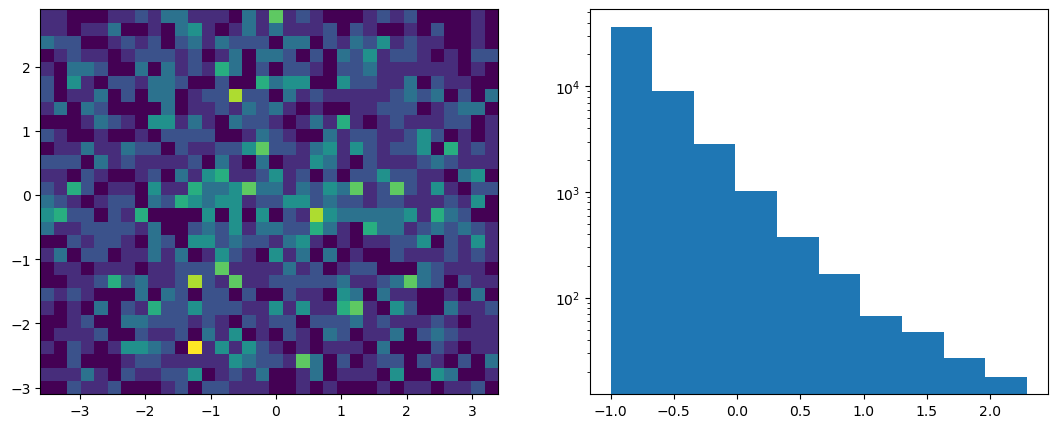

In [16]:
plt.figure(figsize=(13,5))
logenergycutoff = 0.0
plt.subplot(1,2,1)
plt.hist2d(bkg_samples[:,bkg_samples[0]>logenergycutoff][1,:],
           bkg_samples[:,bkg_samples[0]>logenergycutoff][2,:], 
           bins=[longitudeaxistrue-0.5*(longitudeaxistrue[1]-longitudeaxistrue[0]), latitudeaxistrue-0.5*(latitudeaxistrue[1]-latitudeaxistrue[0])])

plt.subplot(1,2,2)
plt.hist(bkg_samples[0,:])
plt.yscale('log')
plt.show()

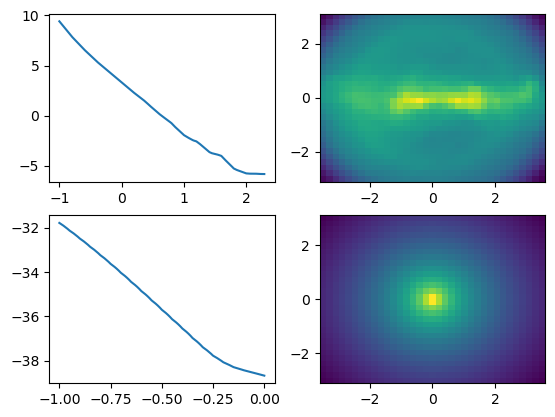

In [17]:

plt.figure()

plt.subplot(221)
plt.plot(log10eaxistrue, bkg_prior((log10eaxistrue,0.0,0.0)))
plt.subplot(222)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),))[160,:,:].T)

plt.subplot(223)
plt.plot(log10eaxistrue, logDMpriorfunc(log10eaxistrue,0.0,0.0, 0.0))
plt.subplot(224)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logDMpriorfunc(0.0,*np.meshgrid(longitudeaxistrue, latitudeaxistrue), 0.0))
plt.show()

In [18]:
bkg_samples[:,bkg_samples[0]>0]

array([[ 0.04      ,  0.47      ,  0.48      , ...,  0.03      ,
         0.61      ,  0.85      ],
       [ 0.20588235,  3.29411765, -3.5       , ...,  1.85294118,
         1.44117647, -2.67647059],
       [ 2.37931034,  3.        ,  2.37931034, ...,  1.96551724,
         0.93103448,  1.13793103]])

In [19]:
bkg_samples[0].shape

(50000,)

In [20]:
100000000/1e8

1.0

# Likelihood Sampling

In [21]:
testfunc = lambda w, x, y, z: w*z+x*y
disc_like = discrete_loglikelihood(logfunction=testfunc, axes=(np.linspace(0,1,100),np.linspace(-1,1,100),), dependent_axes=(np.linspace(1,2,100),np.linspace(-1,1,100),))


Number of input dimensions 2
beeeep
Number of data dimensions 2
Axes shape: (100, 100)


In [22]:
testsamples = disc_like.sample((2.0,-1.0), int(1e5))

In [23]:
testsamples.shape

(100000, 2)

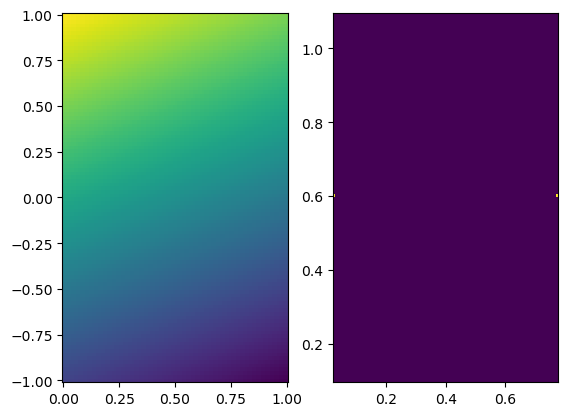

In [24]:
testaxis1, testaxis2 = np.linspace(0,1,100),np.linspace(-1,1,100)

plt.figure()
plt.subplot(121)
plt.pcolormesh(testaxis1, testaxis2, testfunc(*np.meshgrid(testaxis1, testaxis2), 2.0, -1.0,))

plt.subplot(122)
plt.hist2d(testsamples[0], testsamples[1], bins=[100, 100])
plt.show()

In [25]:
from utils3d import edisp_test, psf_test, log10eaxis, longitudeaxis, latitudeaxis
logjacob_log10e_recon = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=edisp_test, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob_log10e_recon,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
edisp_like

Number of input dimensions 1
boop
Axes shape: (171,)


discrete log likelihood class
---------------------------------
name = energy dispersion
logfunction type is <function edisp_test at 0x7fe138931160>
input units of None
over axes log10E recon
with dependent axes ['log10E true', 'lon', 'lat']

In [26]:
sig_log10e_edisp_samples = np.array([edisp_like.sample(signal_event_tuple, 1) for signal_event_tuple in tqdm(sig_samples.T)])

  1%|          | 484/50000 [00:00<00:30, 1639.95it/s]/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/inverse_transform_sampling.py:8: RuntimeWarning: invalid value encountered in subtract
  logpmf = logpmf - logsumexp(logpmf)
100%|██████████| 50000/50000 [00:29<00:00, 1684.70it/s]


In [27]:
signalpriorvals = np.exp(logsumexp(DM_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),), (1.0,))+logenergy_true_logjacob, axis=(1,2)))

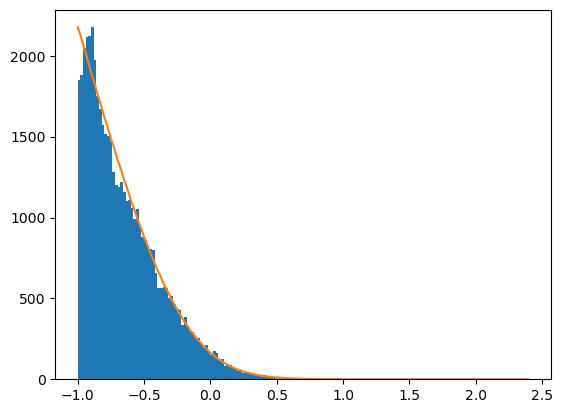

In [28]:
plt.figure()
histvals = plt.hist(np.squeeze(sig_log10e_edisp_samples), bins=log10eaxis)
plt.plot(log10eaxistrue, np.max(histvals[0])*signalpriorvals/np.max(signalpriorvals))
plt.show()

In [29]:
bkg_log10e_edisp_samples = np.array([edisp_like.sample(event_tuple, 1) for event_tuple in tqdm(bkg_samples.T)])

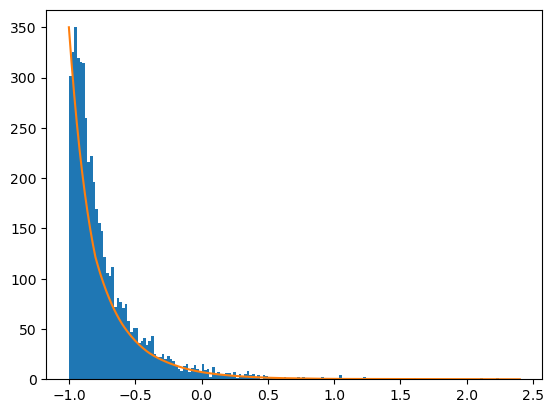

In [ ]:
bkgpriorvals = np.exp(logsumexp(bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),))+logenergy_true_logjacob, axis=(1,2)))

plt.figure()
histvals = plt.hist(np.squeeze(bkg_log10e_edisp_samples), bins=log10eaxis)
plt.plot(log10eaxistrue, np.max(histvals[0])*bkgpriorvals/np.max(bkgpriorvals))
plt.show()

In [ ]:
psf_like = discrete_loglikelihood(logfunction=psf_test, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2
beeeep
Number of data dimensions 2
Axes shape: (18, 15)


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function psf_test at 0x7fc31bf9a940>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

In [ ]:
psf_like(0.0,0.0,0.0,0.0,0.0)

array([4.70864182])

In [ ]:
sig_lonlat_psf_samples =  np.array([psf_like.sample(signal_event_tuple, 1) for signal_event_tuple in tqdm(sig_samples.T)]) 

100%|██████████| 5000/5000 [00:29<00:00, 170.71it/s]


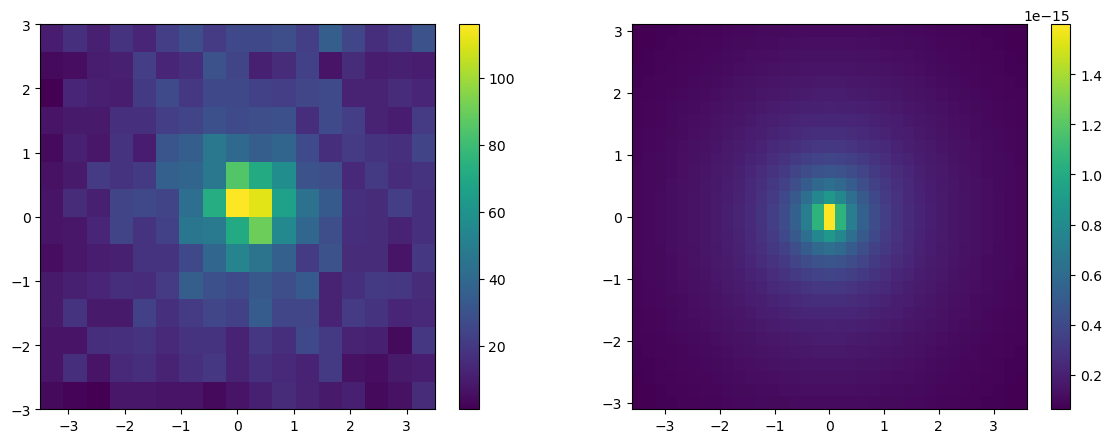

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.hist2d(sig_lonlat_psf_samples[:,0], sig_lonlat_psf_samples[:,1], bins=[longitudeaxis, latitudeaxis])
plt.colorbar()



plt.subplot(122)
signalpriorvals = np.exp(logsumexp(DM_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),), (1.0,))+logenergy_true_logjacob, axis=0))
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, signalpriorvals.T)
plt.colorbar()
plt.show()

In [ ]:
bkg_lonlat_psf_samples =  np.array([psf_like.sample(event_tuple, 1) for event_tuple in tqdm(bkg_samples.T)]) 

100%|██████████| 5000/5000 [00:30<00:00, 162.58it/s]


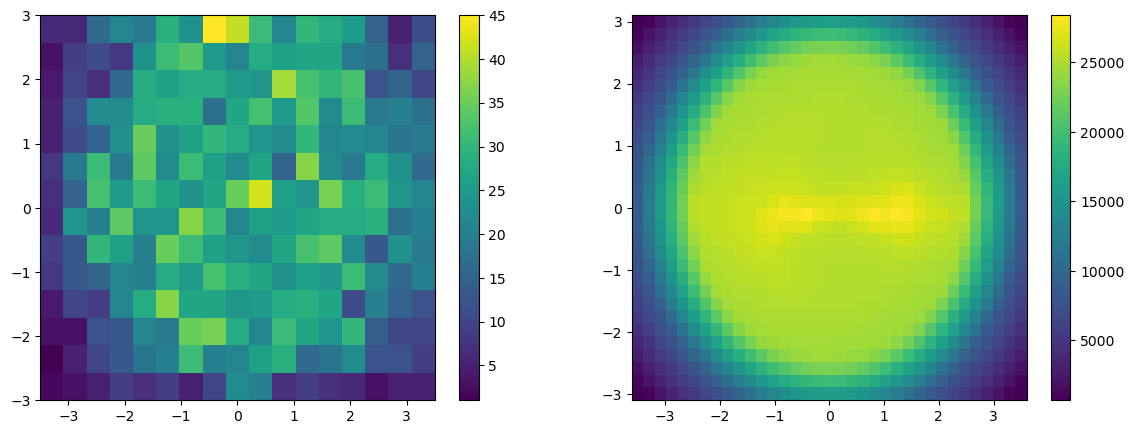

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.hist2d(bkg_lonlat_psf_samples[:,0], bkg_lonlat_psf_samples[:,1], bins=[longitudeaxis, latitudeaxis])
plt.colorbar()



plt.subplot(122)
bkgpriorvals = np.exp(logsumexp(bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),),)+logenergy_true_logjacob, axis=0))
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, bkgpriorvals.T)
plt.colorbar()
plt.show()

In [ ]:
end = perf_counter()

In [ ]:
f'It took {end-start} seconds for {numsamples} events'